In [66]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [67]:
data = pd.read_csv('final_dataset.csv')
data_column = data.iloc[:, 0].values

scaler = StandardScaler()
data_column_normalized = scaler.fit_transform(data_column.reshape(-1, 1)).flatten()


In [68]:
data_tensor = torch.tensor(data_column_normalized, dtype=torch.float32)
X = data_tensor.reshape((16828, 1000))
X = X.unsqueeze(1)

labels = pd.read_csv('label.csv').values
y = labels.squeeze(1).tolist()


error = torch.tensor(list(map(lambda x: [x]*601, y)))
Y = error.flatten()

In [69]:
X_train_valid, X_test, Y_train_valid, Y_test = train_test_split(X, Y-1, test_size=0.3, random_state=42, stratify=Y-1)
X_train , X_valid , Y_train , Y_valid = train_test_split (X_train_valid , Y_train_valid , test_size= 0.25 , random_state=42 , stratify=Y_train_valid)

In [70]:
batch_size = 100
train_dataset = TensorDataset(X_train, Y_train)
valid_dataset = TensorDataset(X_valid,Y_valid)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [71]:
class simpleCNN(nn.Module):
    def __init__(self):
        super(simpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.dropout = nn.Dropout(p=0.5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 250, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [72]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [73]:
model = simpleCNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [74]:
def train_and_evaluate(model, num_epochs, train_loader, valid_loader):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct_train = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct_train.sum()

        loss_hist_train[epoch] /= len(train_loader.dataset)
        accuracy_hist_train[epoch] /= len(train_loader.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct_valid = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct_valid.sum()

        loss_hist_valid[epoch] /= len(valid_loader.dataset)
        accuracy_hist_valid[epoch] /= len(valid_loader.dataset)

        if (epoch + 1) % 20 == 0:
            print(f'Epoch[{epoch+1}]: T_Acc: {accuracy_hist_train[epoch]:.3f}   V_Acc: {accuracy_hist_valid[epoch]:.3f}')

    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


In [75]:
torch.manual_seed(1)
num_epochs = 200
result = train_and_evaluate(model, num_epochs, train_loader, valid_loader)

Epoch[20]: T_Acc: 0.911   V_Acc: 0.925
Epoch[40]: T_Acc: 0.958   V_Acc: 0.960
Epoch[60]: T_Acc: 0.966   V_Acc: 0.954
Epoch[80]: T_Acc: 0.976   V_Acc: 0.967
Epoch[100]: T_Acc: 0.979   V_Acc: 0.970
Epoch[120]: T_Acc: 0.976   V_Acc: 0.970
Epoch[140]: T_Acc: 0.986   V_Acc: 0.976
Epoch[160]: T_Acc: 0.987   V_Acc: 0.979
Epoch[180]: T_Acc: 0.986   V_Acc: 0.971
Epoch[200]: T_Acc: 0.991   V_Acc: 0.977


In [63]:
torch.save(model.state_dict(), 'model.pth')
print('Model saved to model.pth')

Model saved to model.pth


C:\Users\Albaloo Rayaneh\AppData\Local\Temp\ipykernel_23588\1430446203.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_acc_cpu = [torch.tensor(x).cpu().numpy() for x in result[2]]
C:\Users\Albaloo Rayaneh\AppData\Local\Temp\ipykernel_23588\1430446203.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_acc_cpu = [torch.tensor(x).cpu().numpy() for x in result[3]]


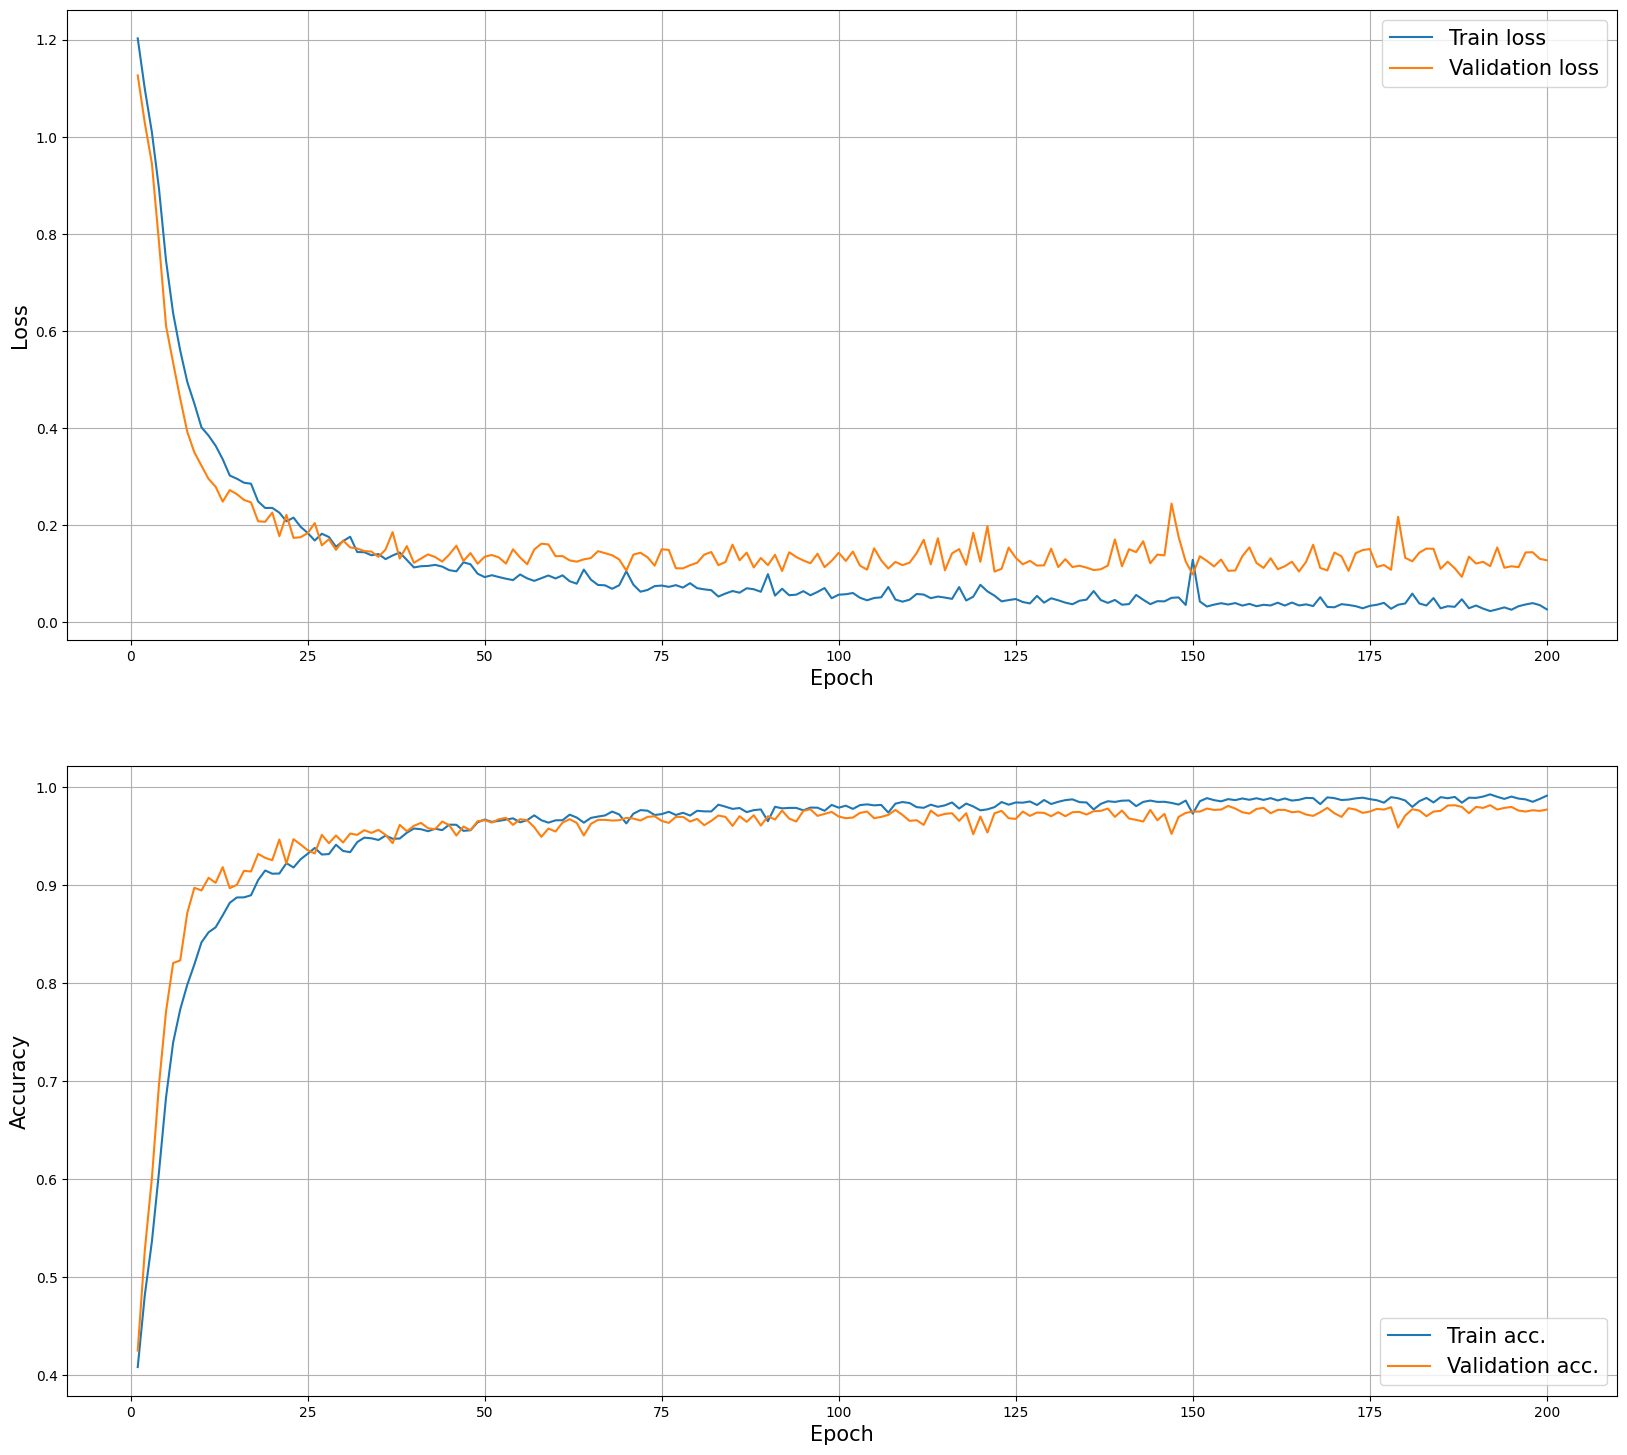

In [76]:
x_arr = np.arange(len(result[0])) + 1

train_loss_cpu = [torch.tensor(x).cpu().numpy() for x in result[0]]
valid_loss_cpu = [torch.tensor(x).cpu().numpy() for x in result[1]]
train_acc_cpu = [torch.tensor(x).cpu().numpy() for x in result[2]]
valid_acc_cpu = [torch.tensor(x).cpu().numpy() for x in result[3]]

fig = plt.figure(figsize=(20, 18))
ax = fig.add_subplot(2, 1, 1)
ax.plot(x_arr, train_loss_cpu, label='Train loss')
ax.plot(x_arr, valid_loss_cpu, label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.grid(True)
ax.legend(fontsize=15)

ax = fig.add_subplot(2, 1, 2)
ax.plot(x_arr, train_acc_cpu, label='Train acc.')
ax.plot(x_arr, valid_acc_cpu, label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.grid(True)
plt.show()


In [13]:
model = simpleCNN().to(device)
model.load_state_dict(torch.load('model.pth'))
model.eval()
print('Model loaded from model.pth')

Model loaded from model.pth


C:\Users\Albaloo Rayaneh\AppData\Local\Temp\ipykernel_25132\142275497.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


In [77]:

def test_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = model(x_batch)
            test_loss += loss_fn(pred, y_batch).item() * y_batch.size(0)
            correct += (torch.argmax(pred, dim=1) == y_batch).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {accuracy:.3f}')

test_model(model, test_loader)    

Test Loss: 0.125, Test Accuracy: 0.980


In [ ]:
# def plot_confusion_matrix(model, test_loader):
#     model.eval()
#     all_preds = []
#     all_labels = []
#     with torch.no_grad():
#         for x_batch, y_batch in test_loader:
#             x_batch, y_batch = x_batch.to(device), y_batch.to(device)
#             pred = model(x_batch)
#             all_preds.extend(torch.argmax(pred, dim=1).cpu().numpy())
#             all_labels.extend(y_batch.cpu().numpy())
#     cm = confusion_matrix(all_labels, all_preds)
#     plt.figure(figsize=(10,7))
#     plt.imshow(cm, interpolation='nearest', cmap='Oranges')
#     plt.title('Confusion Matrix')
#     plt.colorbar()
#     tick_marks = np.arange(len(set(all_labels)))
#     plt.xticks(tick_marks, tick_marks)
#     plt.yticks(tick_marks, tick_marks)
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     for i in range(len(set(all_labels))):
#         for j in range(len(set(all_labels))):
#             plt.text(j, i, cm[i, j], horizontalalignment='center', color='black')
#     plt.show()

# plot_confusion_matrix(model, test_loader)    


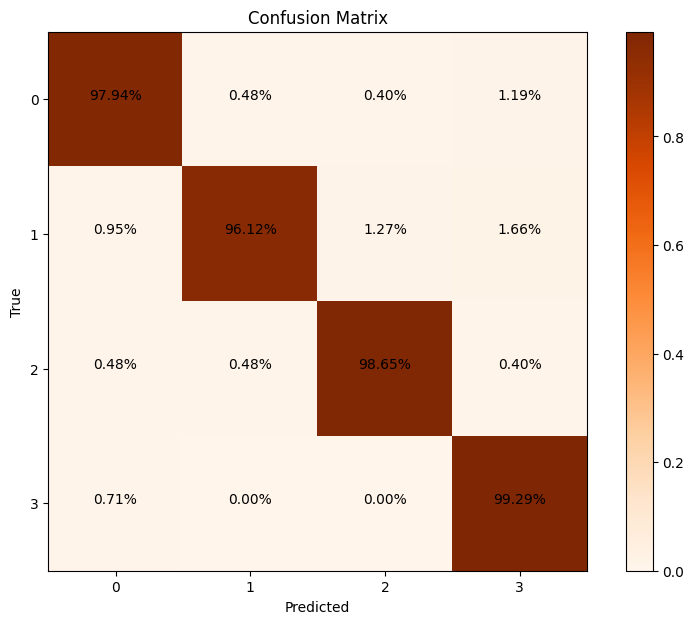

In [80]:

def plot_confusion_matrix(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = model(x_batch)
            all_preds.extend(torch.argmax(pred, dim=1).cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 7))
    plt.imshow(cm_normalized, interpolation='nearest', cmap='Oranges')
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(set(all_labels)))
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel('Predicted')
    plt.ylabel('True')

    for i in range(cm_normalized.shape[0]):
        for j in range(cm_normalized.shape[1]):
            plt.text(j, i, f'{cm_normalized[i, j]:.2%}', horizontalalignment='center', color='black')

    plt.show()

plot_confusion_matrix(model, test_loader)


In [79]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = model(x_batch)
            all_preds.extend(torch.argmax(pred, dim=1).cpu().numpy()) 
            all_labels.extend(y_batch.cpu().numpy())
    
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, digits=4))


evaluate_model(model, test_loader)


Classification Report:
              precision    recall  f1-score   support

           0     0.9786    0.9794    0.9790      1262
           1     0.9902    0.9612    0.9755      1262
           2     0.9834    0.9865    0.9850      1263
           3     0.9683    0.9929    0.9804      1262

    accuracy                         0.9800      5049
   macro avg     0.9801    0.9800    0.9800      5049
weighted avg     0.9801    0.9800    0.9800      5049

